In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib notebook

Default plot settings.

In [2]:
try:
    import seaborn as sns
    sns.set()
    sns.set_style("whitegrid")
    sns.set_context("poster")
except ImportError as e:
    print("Cannot import seaborn.")
    print("Consider installing it for nice plot !")

mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


# Load data




In [3]:
from dataset import load_hit_generator, load_hit_truth_generator, load_hit_particle_generator

In [4]:
data_path = "./training/"

In [5]:
event_truth_generator = load_hit_truth_generator(data_path)
event_id, event, truth = next(event_truth_generator)


event['r'] = np.hypot(event['x'],event['y'])
event['phi'] = np.arctan2(event['y'], event['x'])

first_layer = event.loc[(event['r']<40)]
remaining_layers = event.loc[(event['r']>=40)]
truth_first_layer = truth.loc[(event['r']<40)]

In [6]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz
0,1,4513632670973952,605.722,-503.528,-241.204,0.861402,-1.022420,-0.418102
1,2,99083521129185280,-521.111,581.760,-771.116,-0.159444,0.522309,-0.512570
2,3,171158501194727424,601.567,489.297,476.313,0.942753,0.475214,0.626167
3,4,63051288136384512,741.358,708.926,-187.819,0.211256,0.617001,-0.116892
4,5,81066167682203648,-799.625,-641.450,1035.490,-0.535081,-0.807179,0.968362


In [8]:
r_bins = 9
phi_bins = 100
z_bins = 100
phi_width = 2.0*np.pi/float(phi_bins)
z_width = 2200./float(z_bins)

r_grid = np.array([0, 40, 80, 120, 200, 300, 500, 700, 900])
z_grid = np.linspace(-1100, 1100, z_bins)
phi_grid = np.linspace(-np.pi, np.pi, phi_bins)
    
def get_phi(x, y):
    return np.arctan2(y, x)

def discretize(evt):
    image = np.zeros((r_bins,phi_bins,z_bins, 1))
    hits_row_names = list(evt.columns)
    for hit in evt.itertuples():
        x = hit[hits_row_names.index('x')+1]
        y = hit[hits_row_names.index('y')+1]
        z = hit[hits_row_names.index('z')+1]
        r = hit[hits_row_names.index('r')+1]
        ir = np.digitize(r,r_grid,right=False)-1
        phi = hit[hits_row_names.index('phi')+1]
        iphi = int((phi+np.pi)/phi_width)
        iz = int((z+1100)/z_width)
        image[ir,iphi,iz,0] = 1
    return image

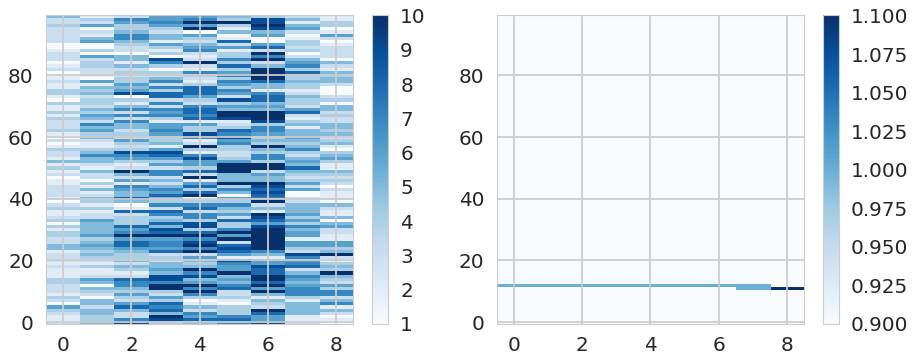

In [10]:
image = discretize(event)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
im = plt.imshow(np.sum(image[:,:,:,0],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', vmin=1, vmax=10,cmap='Blues')
plt.colorbar(im)

plt.subplot(1,2,2)
truth_event_particle = pd.merge(event[truth.particle_id==4504011944230912],
                                truth[truth.particle_id==4504011944230912],
                                on='hit_id', how='left', validate='one_to_one')
truth_image = discretize(truth_event_particle)
t_im = plt.imshow(np.sum(truth_image[:,:,:,0],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', vmin=1, vmax=1, cmap='Blues')
plt.colorbar(t_im)
plt.tight_layout()

In [14]:
# Load some data
event_truth_generator = load_hit_truth_generator(data_path)
event_id, event, truth = next(event_truth_generator)

# comput r, phi
event['r'] = np.hypot(event['x'],event['y'])
event['phi'] = np.arctan2(event['y'], event['x'])

# get first layers
first_layer = event.loc[(event['r']<40)]
truth_first_layer = truth.loc[(event['r']<40)]

# Count the number of first-layer hits, which will be my seeds
num_seeds = len(first_layer)
print('Number of seeds: %d' % num_seeds)
print('Preparing training data...')
# Training input will contain the seed hit followed by the rest of the event
train_input = np.zeros((num_seeds, r_bins, phi_bins, z_bins))
full_input = discretize(event)
# Training targets will be images of the individual signal tracks
train_target = np.zeros_like(train_input)
    
# Loop over training samples to prepare (seeds)
for i_sample in range(num_seeds):
    i_hit = first_layer.iloc[i_sample]
    # Find all the hits from this event
    #ev_idx = evids == y[i_hit,0]
    #ev_lay, ev_phi = layers[ev_idx], phis[ev_idx]
    #r = i_hit['r']
    phi = i_hit['phi']
    z = i_hit['z']
    #ir = np.digitize(r,r_grid,right=False)-1
    iphi = int((phi+np.pi)/phi_width)
    iz = int((z+1100)/z_width)
    # Fill the input first layer with just the seed hit
    train_input[i_sample,0,iphi,iz] = 1
    # Fill the other layers with all remaining event hits
    for ir in range(1, r_bins):
        train_input[i_sample, ir, :, :] = full_input[ir, :, :, 0]

    # Fill target with hits from this track
    #ev_trk_idx = ev_trkid == y[i_hit,1]
    i_truth = truth_first_layer.iloc[i_sample]
    if i_truth['particle_id']==0: continue
        
    truth_event_particle = pd.merge(event[truth.particle_id==i_truth['particle_id']],
                                    truth[truth.particle_id==i_truth['particle_id']],
                                    on='hit_id', how='left', validate='one_to_one')
    truth_image = discretize(truth_event_particle)
    train_target[i_sample, :, :, :] = truth_image[:,:,:,0]

Number of seeds: 579
Preparing training data...


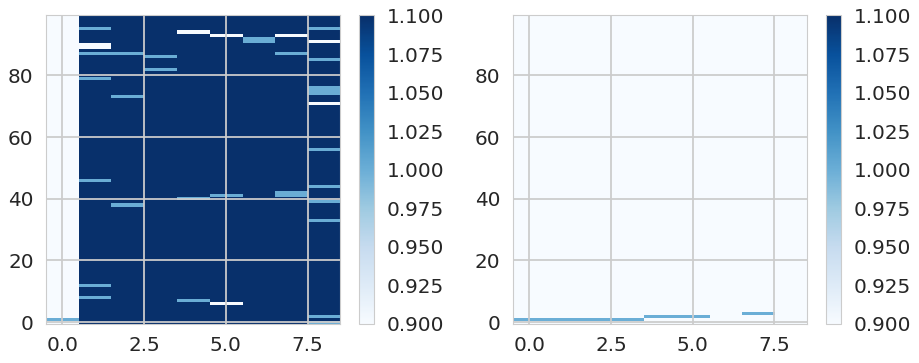

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
im = plt.imshow(np.sum(train_input[2],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', vmin=1, vmax=1, cmap='Blues')
plt.colorbar(im)
plt.subplot(1,2,2)
t_im = plt.imshow(np.sum(train_target[2],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', vmin=1, vmax=1, cmap='Blues')
plt.colorbar(t_im)
plt.tight_layout()

In [16]:
import keras
from keras.layers import Input, Dense, LSTM, TimeDistributed, Reshape
from keras.models import Model
def build_model(num_hidden, length, dim1, dim2,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = Input(shape=(length, dim1, dim2),name='inputs')
    reshape = Reshape((length, dim1*dim2),name='reshape_inputs')(inputs)
    hidden = LSTM(units=num_hidden, return_sequences=True,name='lstm')(reshape)
    dense = TimeDistributed(Dense(dim1*dim2, activation='softmax'),name='dense')(hidden)
    outputs = Reshape((length, dim1, dim2),name='reshape_outputs')(dense)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Using TensorFlow backend.


In [ ]:
print('Starting training...')
model = build_model(500, r_bins, phi_bins, z_bins)
model.summary()
history = model.fit(train_input, train_target, batch_size=128, epochs=20)

Starting training...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 9, 100, 100)       0         
_________________________________________________________________
reshape_inputs (Reshape)     (None, 9, 10000)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 9, 500)            21002000  
_________________________________________________________________
dense (TimeDistributed)      (None, 9, 10000)          5010000   
_________________________________________________________________
reshape_outputs (Reshape)    (None, 9, 100, 100)       0         
Total params: 26,012,000
Trainable params: 26,012,000
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
579/579 [==============================] - 3s 6ms/step - loss: 0.0374 - acc: 0.0030
Epoch 2/100
5

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
im = plt.imshow(np.sum(train_input[2],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', vmin=1, vmax=1, cmap='Blues')
plt.colorbar(im)
plt.subplot(1,3,2)
t_im = plt.imshow(np.sum(train_target[2],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower',vmin=1, vmax=1, cmap='Blues')
plt.colorbar(t_im)
plt.subplot(1,3,3)
predict = model.predict(train_input[2:3,:,:,:])
p_im = plt.imshow(np.sum(predict[0],axis=-1).T, interpolation='none',
               aspect='auto', origin='lower', cmap='Blues')
plt.colorbar(p_im)
plt.tight_layout()